In [2]:
import os
import re
import nltk
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from tensorflow.keras import utils
from tensorflow.keras.initializers import RandomNormal
%matplotlib notebook
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import BatchNormalization, Conv1D, MaxPooling1D, MaxPooling2D, LSTM
from tensorflow.keras.layers import Dense,Input,Activation, Embedding, Flatten, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Concatenate
import random as rn
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from keras import backend
from itertools import combinations
import datetime
from sklearn.metrics import roc_auc_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Loading

In [4]:
#read the csv file
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/cleaned_data.csv')

In [5]:
print(df.shape)
df.head()

(109248, 10)


,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,0,0,students english learners working english seco...,154.60,23
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,7,1,students arrive school eager learn polite gene...,299.00,1
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,1,0,true champions not always ones win guts mia ha...,516.85,22
3,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,4,1,work unique school filled esl english second l...,232.90,4
4,mrs,tx,grades_prek_2,math_science,mathematics,1,1,second grade classroom next year made around 2...,67.98,4


# 2. Data Preprocessing

In [6]:
y = df['project_is_approved']
X = df.drop('project_is_approved',axis=1)

In [7]:
# perform stratified train test split on the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=0)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(87398, 9)
(21850, 9)
(87398,)
(21850,)


## 2.2 Text Vectorization

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
token_text = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',lower=True, split=' ')
token_text.fit_on_texts(X_train['essay'])

In [60]:
pickle.dump((token_text),open('/content/drive/MyDrive/token.pkl','wb'))

In [10]:
sequence_x_train_text = token_text.texts_to_sequences(X_train['essay'])
sequence_x_test_text = token_text.texts_to_sequences(X_test['essay'])

In [11]:
len(token_text.word_index)

51489

In [12]:
lengths = []

for i in sequence_x_train_text:
    lengths.append(len(i))

max_length = max(lengths)
print(max_length)

320


In [13]:
for i in range(0,110,10):
    print('{}th percentile is: {}'.format(i,np.percentile(lengths,i)))

0th percentile is: 69.0
10th percentile is: 101.0
20th percentile is: 107.0
30th percentile is: 114.0
40th percentile is: 121.0
50th percentile is: 129.0
60th percentile is: 139.0
70th percentile is: 151.0
80th percentile is: 166.0
90th percentile is: 191.0
100th percentile is: 320.0


In [14]:
for i in range(91,101):
    print('{}th percentile is: {}'.format(i,np.percentile(lengths,i)))

91th percentile is: 194.0
92th percentile is: 198.0
93th percentile is: 202.0
94th percentile is: 207.0
95th percentile is: 212.0
96th percentile is: 218.0
97th percentile is: 225.0
98th percentile is: 234.0
99th percentile is: 247.02999999999884
100th percentile is: 320.0


In [15]:
a=[99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]

for i in a:
    print('{}th percentile is: {}'.format(i,np.percentile(lengths,i)))

99.1th percentile is: 249.0
99.2th percentile is: 251.0
99.3th percentile is: 253.0
99.4th percentile is: 256.0
99.5th percentile is: 259.0
99.6th percentile is: 262.4119999999966
99.7th percentile is: 267.0
99.8th percentile is: 272.0
99.9th percentile is: 280.0
100th percentile is: 320.0


In [16]:
x_train_padding = pad_sequences(sequence_x_train_text, maxlen=320, padding='post',truncating='post')
x_test_padding = pad_sequences(sequence_x_test_text, maxlen=320, padding='post',truncating='post')

### 2.2.1. Glove Vector

In [ ]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('/content/drive/MyDrive/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
embedding_matrix_text_glove = np.zeros(((len(token_text.word_index)+1), 300))
for word, i in token_text.word_index.items():
    if word in glove_words:
        embedding_vector = model[word]
        if embedding_vector is not None:
            embedding_matrix_text_glove[i] = embedding_vector

In [ ]:
print(embedding_matrix_text_glove.shape)

(51490, 300)


### 2.2.2. Fast Text Embedding

In [33]:
embedding_index={}
with open('/content/drive/MyDrive/crawl-300d-2M.vec') as f:
  for line in f:
    value=line.split()
    word=value[0]
    vector=np.asarray(value[1:],dtype='float32')
    embedding_index[word]=vector

In [34]:
embedding_matrix_text_fast = np.zeros(((len(token_text.word_index)+1), 300))
for word, i in token_text.word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix_text_fast[i] = embedding_vector

In [35]:
print(embedding_matrix_text_fast.shape)

(51490, 300)


## 2.3 Categorical feature vectorization

#### School State

In [35]:
from sklearn.preprocessing import OrdinalEncoder

# Create encoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)

# Fit on training data
ordinal_encoder.fit(X_train['school_state'].values.reshape(-1,1))

# Transform, notice that 0 and 6 are values that were never seen before
ordinal_encoder_ss_train = ordinal_encoder.transform(X_train['school_state'].values.reshape(-1,1))
ordinal_encoder_ss_test = ordinal_encoder.transform(X_test['school_state'].values.reshape(-1,1))

#### Teacher Prefix

In [36]:
# Create encoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)

# Fit on training data
ordinal_encoder.fit(X_train['teacher_prefix'].values.reshape(-1,1))

# Transform, notice that 0 and 6 are values that were never seen before
ordinal_encoder_tp_train = ordinal_encoder.transform(X_train['teacher_prefix'].values.reshape(-1,1))
ordinal_encoder_tp_test = ordinal_encoder.transform(X_test['teacher_prefix'].values.reshape(-1,1))

#### Project Grade Category

In [37]:
# Create encoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)

# Fit on training data
ordinal_encoder.fit(X_train['project_grade_category'].values.reshape(-1,1))

# Transform, notice that 0 and 6 are values that were never seen before
ordinal_encoder_pgc_train = ordinal_encoder.transform(X_train['project_grade_category'].values.reshape(-1,1))
ordinal_encoder_pgc_test = ordinal_encoder.transform(X_test['project_grade_category'].values.reshape(-1,1))

#### Project Subject Categories

In [38]:
# Create encoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)

# Fit on training data
ordinal_encoder.fit(X_train['project_subject_categories'].values.reshape(-1,1))

# Transform, notice that 0 and 6 are values that were never seen before
ordinal_encoder_cc_train = ordinal_encoder.transform(X_train['project_subject_categories'].values.reshape(-1,1))
ordinal_encoder_cc_test = ordinal_encoder.transform(X_test['project_subject_categories'].values.reshape(-1,1))

#### Project Subject Subcategories

In [39]:
# Create encoder
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)

# Fit on training data
ordinal_encoder.fit(X_train['project_subject_subcategories'].values.reshape(-1,1))

# Transform, notice that 0 and 6 are values that were never seen before
ordinal_encoder_csc_train = ordinal_encoder.transform(X_train['project_subject_subcategories'].values.reshape(-1,1))
ordinal_encoder_csc_test = ordinal_encoder.transform(X_test['project_subject_subcategories'].values.reshape(-1,1))

#### Numerical feature Vectorization

In [61]:
from sklearn.preprocessing import StandardScaler

standar_tpp = StandardScaler()

standar_tpp.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
teacher_number_of_previously_posted_projects_train = standar_tpp.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
teacher_number_of_previously_posted_projects_test = standar_tpp.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


In [62]:
standar_price = StandardScaler()
standar_price.fit(X_train['price'].values.reshape(-1,1))
price_train = standar_price.transform(X_train['price'].values.reshape(-1,1))
price_test = standar_price.transform(X_test['price'].values.reshape(-1,1))

In [63]:
standar_qnty = StandardScaler()
standar_qnty.fit(X_train['quantity'].values.reshape(-1,1))
x_train_quantity = standar_qnty.transform(X_train['quantity'].values.reshape(-1,1))
x_test_quantity = standar_qnty.transform(X_test['quantity'].values.reshape(-1,1))

In [64]:
numeric_data_train = np.hstack((teacher_number_of_previously_posted_projects_train,price_train,x_train_quantity))
numeric_data_test = np.hstack((teacher_number_of_previously_posted_projects_test,price_test,x_test_quantity))

In [65]:
pickle.dump((standar_tpp, standar_price, standar_qnty),open('/content/drive/MyDrive/scales.pkl','wb'))

# 3. Modeling

In [27]:
def auroc(y_true, y_pred):
    value = tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)
    return value

In [29]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [30]:
from collections import Counter

print(Counter(y_train))

Counter({1: 74164, 0: 13234})


In [31]:
class_weights = {0:3 , 1:1}

## 3.1 LSTM on text data, embedding on categorical and dense on numerical (Embedding is Glove trainable=True)

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_sequence_data = Input(shape=(320,), name='input_sequence_data')
embedding_text = Embedding(len(token_text.word_index)+1,embedding_matrix_text_glove.shape[1],
                                 weights=[embedding_matrix_text_glove],input_length=320,trainable=True, name='embedding_text')(input_sequence_data)
lstm_layer = LSTM(100, return_sequences = True, name= 'lstm_layer')(embedding_text)
text_layer = Flatten(name= 'text_layer')(lstm_layer)

input_school_state = Input(shape=(1,), name='input_school_state')
embedding_ss = Embedding(len(np.unique(ordinal_encoder_ss_train)), 2, input_length=1, name= 'embedding_ss')(input_school_state)
ss_layer = Flatten(name= 'ss_layer')(embedding_ss)

input_pgc = Input(shape=(1,), name= 'input_pgc')
embedding_pgc = Embedding(len(np.unique(ordinal_encoder_pgc_train)), 2, input_length=1, name= 'embedding_pgc')(input_pgc)
pgc_layer = Flatten(name='pgc_layer')(embedding_pgc)

input_cc = Input(shape=(1,), name= 'input_cc')
embedding_cc = Embedding(len(np.unique(ordinal_encoder_cc_train)), 2, input_length=1, name='embedding_cc')(input_cc)
cc_layer = Flatten(name='cc_layer')(embedding_cc)

input_csc = Input(shape=(1,), name='input_csc')
embedding_csc = Embedding(len(np.unique(ordinal_encoder_csc_train)), 2, input_length=1, name='embedding_csc')(input_csc)
csc_layer = Flatten(name='csc_layer')(embedding_csc)

input_tp = Input(shape=(1,), name='input_tp')
embedding_tp = Embedding(len(np.unique(ordinal_encoder_tp_train)), 2, input_length=1, name='embedding_tp')(input_tp)
tp_layer = Flatten(name='tp_layer')(embedding_tp)

input_numeric_data = Input(shape=(7,), name='input_numeric_data')
numeric_layer = Dense(4096, activation='relu', kernel_initializer='he_normal', name='numeric_layer')(input_numeric_data)

merge_layer = Concatenate(axis=-1)([text_layer, ss_layer, pgc_layer, cc_layer, csc_layer, tp_layer, numeric_layer])

dense_layer1 = Dense(4096, activation='relu', kernel_initializer='he_normal', name='dense_layer1')(merge_layer)
dense_layer2 = Dense(4096, activation='relu', kernel_initializer='he_normal', name='dense_layer2')(dense_layer1)
dropout_layer1 = Dropout(0.5, name='dropout_layer1')(dense_layer2)
dense_layer3 = Dense(2048, activation='relu', kernel_initializer='he_normal', name='dense_layer3')(dropout_layer1)
dense_layer4 = Dense(2048, activation='relu', kernel_initializer='he_normal', name='dense_layer4')(dense_layer3)
dropout_layer2 = Dropout(0.5, name='dropout_layer2')(dense_layer4)
dense_layer5 = Dense(1024, activation='relu', kernel_initializer='he_normal', name='dense_layer5')(dropout_layer2)
dense_layer6 = Dense(1024, activation='relu', kernel_initializer='he_normal', name='dense_layer6')(dense_layer5)
dropout_layer3 = Dropout(0.5, name='dropout_layer3')(dense_layer6)
dense_layer7 = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense_layer7')(dropout_layer3)


output_layer = Dense(1, activation='sigmoid')(dense_layer7)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
lr_scheduler =tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

model1 = Model(inputs=[input_sequence_data, input_school_state, input_pgc, input_cc, input_csc, input_tp, input_numeric_data], outputs= output_layer)

model1.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy', auroc])

model1.fit([x_train_padding, ordinal_encoder_ss_train, ordinal_encoder_pgc_train, 
           ordinal_encoder_cc_train, ordinal_encoder_csc_train, ordinal_encoder_tp_train, numeric_data_train], y_train, 
          validation_data=([x_test_padding, ordinal_encoder_ss_test, ordinal_encoder_pgc_test, 
           ordinal_encoder_cc_test, ordinal_encoder_csc_test, ordinal_encoder_tp_test, numeric_data_test], y_test), 
           batch_size=1100, epochs=7, callbacks=[tensorboard_callback, lr_scheduler], class_weight=class_weights)

Epoch 1/7
75/75 [==============================] - 52s 647ms/step - loss: 0.9014 - accuracy: 0.7534 - auroc: 0.5585 - val_loss: 0.5190 - val_accuracy: 0.8464 - val_auroc: 0.6436 - lr: 1.0000e-04
Epoch 2/7
75/75 [==============================] - 46s 618ms/step - loss: 0.8285 - accuracy: 0.7988 - auroc: 0.6189 - val_loss: 0.5267 - val_accuracy: 0.8008 - val_auroc: 0.6704 - lr: 1.0000e-04
Epoch 3/7
75/75 [==============================] - 46s 610ms/step - loss: 0.7900 - accuracy: 0.8007 - auroc: 0.6810 - val_loss: 0.5020 - val_accuracy: 0.8112 - val_auroc: 0.7201 - lr: 1.0000e-04
Epoch 4/7
75/75 [==============================] - 45s 605ms/step - loss: 0.7544 - accuracy: 0.8013 - auroc: 0.7221 - val_loss: 0.4904 - val_accuracy: 0.8143 - val_auroc: 0.7357 - lr: 1.0000e-04
Epoch 5/7
75/75 [==============================] - 46s 613ms/step - loss: 0.7292 - accuracy: 0.8109 - auroc: 0.7464 - val_loss: 0.4627 - val_accuracy: 0.8327 - val_auroc: 0.7485 - lr: 1.0000e-04
Epoch 6/7
75/75 [========

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sequence_data (InputLaye  [(None, 320)]       0           []                               
 r)                                                                                               
                                                                                                  
 embedding_text (Embedding)     (None, 320, 300)     15057900    ['input_sequence_data[0][0]']    
                                                                                                  
 input_school_state (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                              

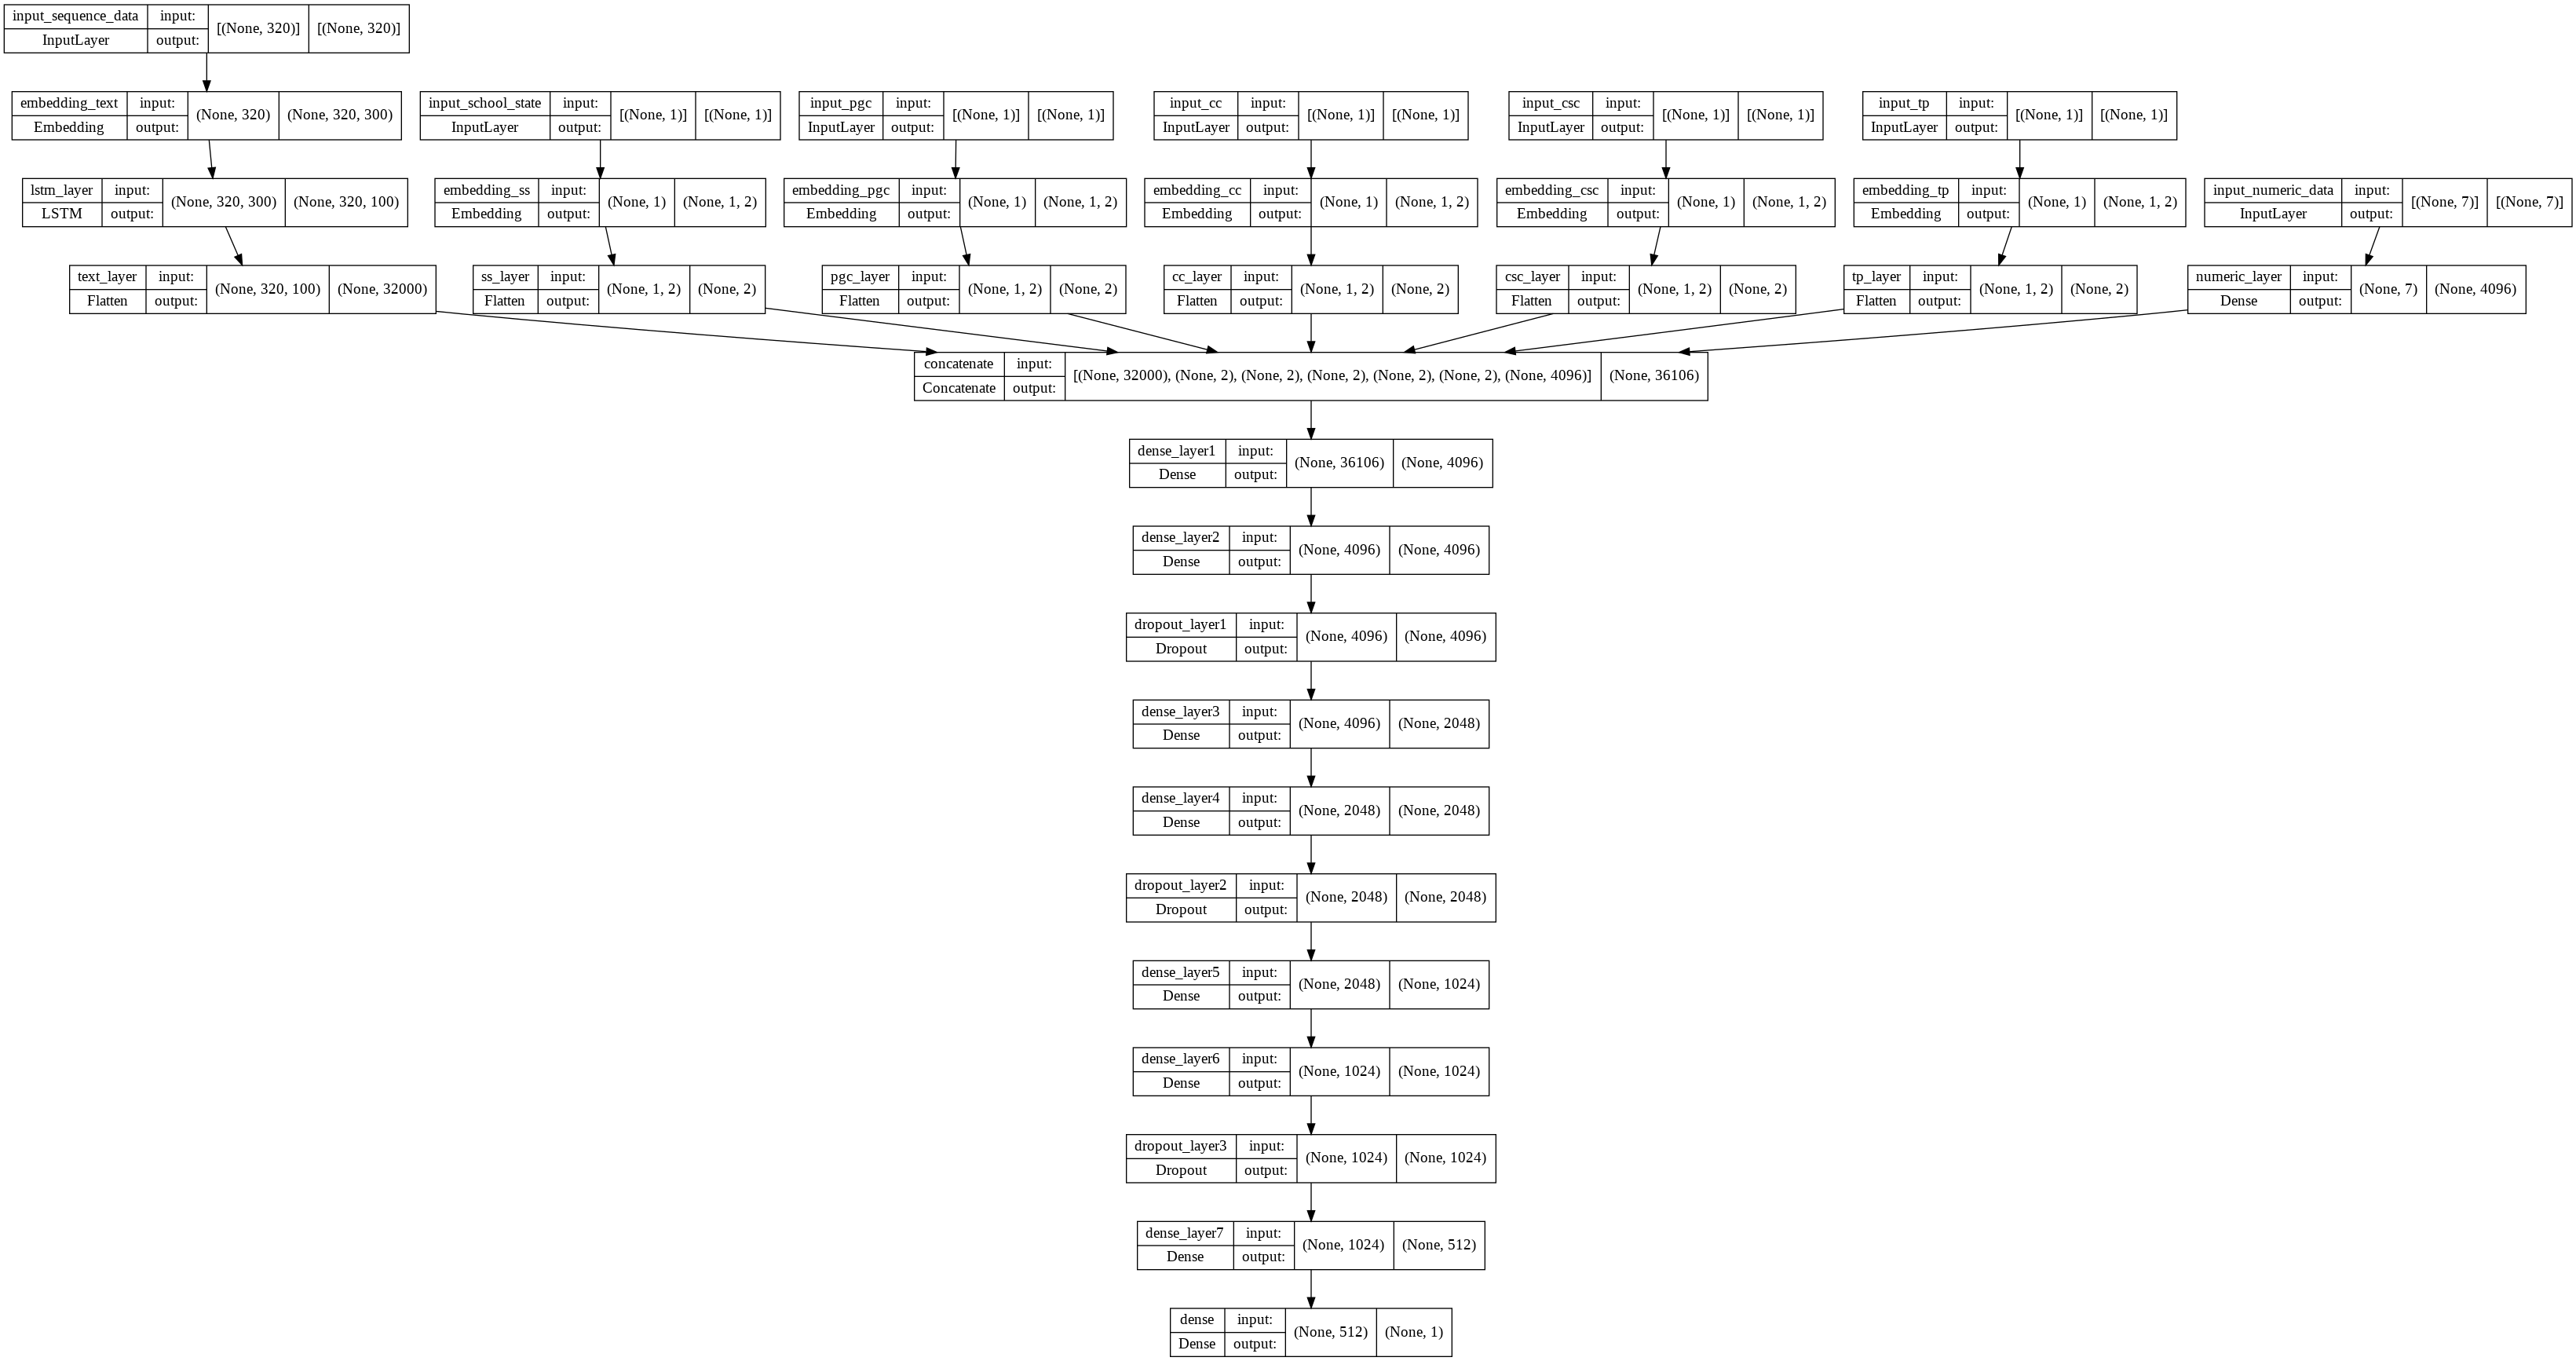

In [ ]:
path = 'model_1.png'
tf.keras.utils.plot_model(model1, to_file=path, show_shapes=True)

In [ ]:
model1.save('/content/drive/MyDrive/model1.h5')

## 3.2 LSTM on text data, embedding on categorical and dense on numerical (Embedding is Fast Text trainable=True)

In [ ]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_sequence_data = Input(shape=(320,), name='input_sequence_data')
embedding_text = Embedding(len(token_text.word_index)+1,embedding_matrix_text_fast.shape[1],
                                 weights=[embedding_matrix_text_fast],input_length=320,trainable=True, name='embedding_text')(input_sequence_data)
lstm_layer = LSTM(100, return_sequences = True, name= 'lstm_layer')(embedding_text)
text_layer = Flatten(name= 'text_layer')(lstm_layer)

input_school_state = Input(shape=(1,), name='input_school_state')
embedding_ss = Embedding(len(np.unique(ordinal_encoder_ss_train)), 2, input_length=1, name= 'embedding_ss')(input_school_state)
ss_layer = Flatten(name= 'ss_layer')(embedding_ss)

input_pgc = Input(shape=(1,), name= 'input_pgc')
embedding_pgc = Embedding(len(np.unique(ordinal_encoder_pgc_train)), 2, input_length=1, name= 'embedding_pgc')(input_pgc)
pgc_layer = Flatten(name='pgc_layer')(embedding_pgc)

input_cc = Input(shape=(1,), name= 'input_cc')
embedding_cc = Embedding(len(np.unique(ordinal_encoder_cc_train)), 2, input_length=1, name='embedding_cc')(input_cc)
cc_layer = Flatten(name='cc_layer')(embedding_cc)

input_csc = Input(shape=(1,), name='input_csc')
embedding_csc = Embedding(len(np.unique(ordinal_encoder_csc_train)), 2, input_length=1, name='embedding_csc')(input_csc)
csc_layer = Flatten(name='csc_layer')(embedding_csc)

input_tp = Input(shape=(1,), name='input_tp')
embedding_tp = Embedding(len(np.unique(ordinal_encoder_tp_train)), 2, input_length=1, name='embedding_tp')(input_tp)
tp_layer = Flatten(name='tp_layer')(embedding_tp)

input_numeric_data = Input(shape=(7,), name='input_numeric_data')
numeric_layer = Dense(4096, activation='relu', kernel_initializer='he_normal', name='numeric_layer')(input_numeric_data)

merge_layer = Concatenate(axis=-1)([text_layer, ss_layer, pgc_layer, cc_layer, csc_layer, tp_layer, numeric_layer])

dense_layer1 = Dense(4096, activation='relu', kernel_initializer='he_normal', name='dense_layer1')(merge_layer)
dense_layer2 = Dense(4096, activation='relu', kernel_initializer='he_normal', name='dense_layer2')(dense_layer1)
dropout_layer1 = Dropout(0.5, name='dropout_layer1')(dense_layer2)
dense_layer3 = Dense(2048, activation='relu', kernel_initializer='he_normal', name='dense_layer3')(dropout_layer1)
dense_layer4 = Dense(2048, activation='relu', kernel_initializer='he_normal', name='dense_layer4')(dense_layer3)
dropout_layer2 = Dropout(0.5, name='dropout_layer2')(dense_layer4)
dense_layer5 = Dense(1024, activation='relu', kernel_initializer='he_normal', name='dense_layer5')(dropout_layer2)
dense_layer6 = Dense(1024, activation='relu', kernel_initializer='he_normal', name='dense_layer6')(dense_layer5)
dropout_layer3 = Dropout(0.5, name='dropout_layer3')(dense_layer6)
dense_layer7 = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense_layer7')(dropout_layer3)


output_layer = Dense(1, activation='sigmoid')(dense_layer7)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
lr_scheduler =tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

model2 = Model(inputs=[input_sequence_data, input_school_state, input_pgc, input_cc, input_csc, input_tp, input_numeric_data], outputs= output_layer)

model2.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy', auroc])

model2.fit([x_train_padding, ordinal_encoder_ss_train, ordinal_encoder_pgc_train, 
           ordinal_encoder_cc_train, ordinal_encoder_csc_train, ordinal_encoder_tp_train, numeric_data_train], y_train, 
          validation_data=([x_test_padding, ordinal_encoder_ss_test, ordinal_encoder_pgc_test, 
           ordinal_encoder_cc_test, ordinal_encoder_csc_test, ordinal_encoder_tp_test, numeric_data_test], y_test), 
           batch_size=1100, epochs=7, callbacks=[tensorboard_callback, lr_scheduler], class_weight=class_weights)

Epoch 1/7
75/75 [==============================] - 53s 642ms/step - loss: 0.8955 - accuracy: 0.7573 - auroc: 0.5665 - val_loss: 0.5223 - val_accuracy: 0.8094 - val_auroc: 0.6493 - lr: 1.0000e-04
Epoch 2/7
75/75 [==============================] - 46s 610ms/step - loss: 0.8214 - accuracy: 0.7977 - auroc: 0.6362 - val_loss: 0.4892 - val_accuracy: 0.7961 - val_auroc: 0.7133 - lr: 1.0000e-04
Epoch 3/7
75/75 [==============================] - 47s 622ms/step - loss: 0.7649 - accuracy: 0.7966 - auroc: 0.7165 - val_loss: 0.4637 - val_accuracy: 0.8196 - val_auroc: 0.7395 - lr: 1.0000e-04
Epoch 4/7
75/75 [==============================] - 46s 608ms/step - loss: 0.7301 - accuracy: 0.8093 - auroc: 0.7469 - val_loss: 0.4599 - val_accuracy: 0.8085 - val_auroc: 0.7494 - lr: 1.0000e-04
Epoch 5/7
75/75 [==============================] - 45s 607ms/step - loss: 0.7090 - accuracy: 0.8161 - auroc: 0.7637 - val_loss: 0.4798 - val_accuracy: 0.7953 - val_auroc: 0.7604 - lr: 1.0000e-04
Epoch 6/7
75/75 [========

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sequence_data (InputLaye  [(None, 320)]       0           []                               
 r)                                                                                               
                                                                                                  
 embedding_text (Embedding)     (None, 320, 300)     15057900    ['input_sequence_data[0][0]']    
                                                                                                  
 input_school_state (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                              

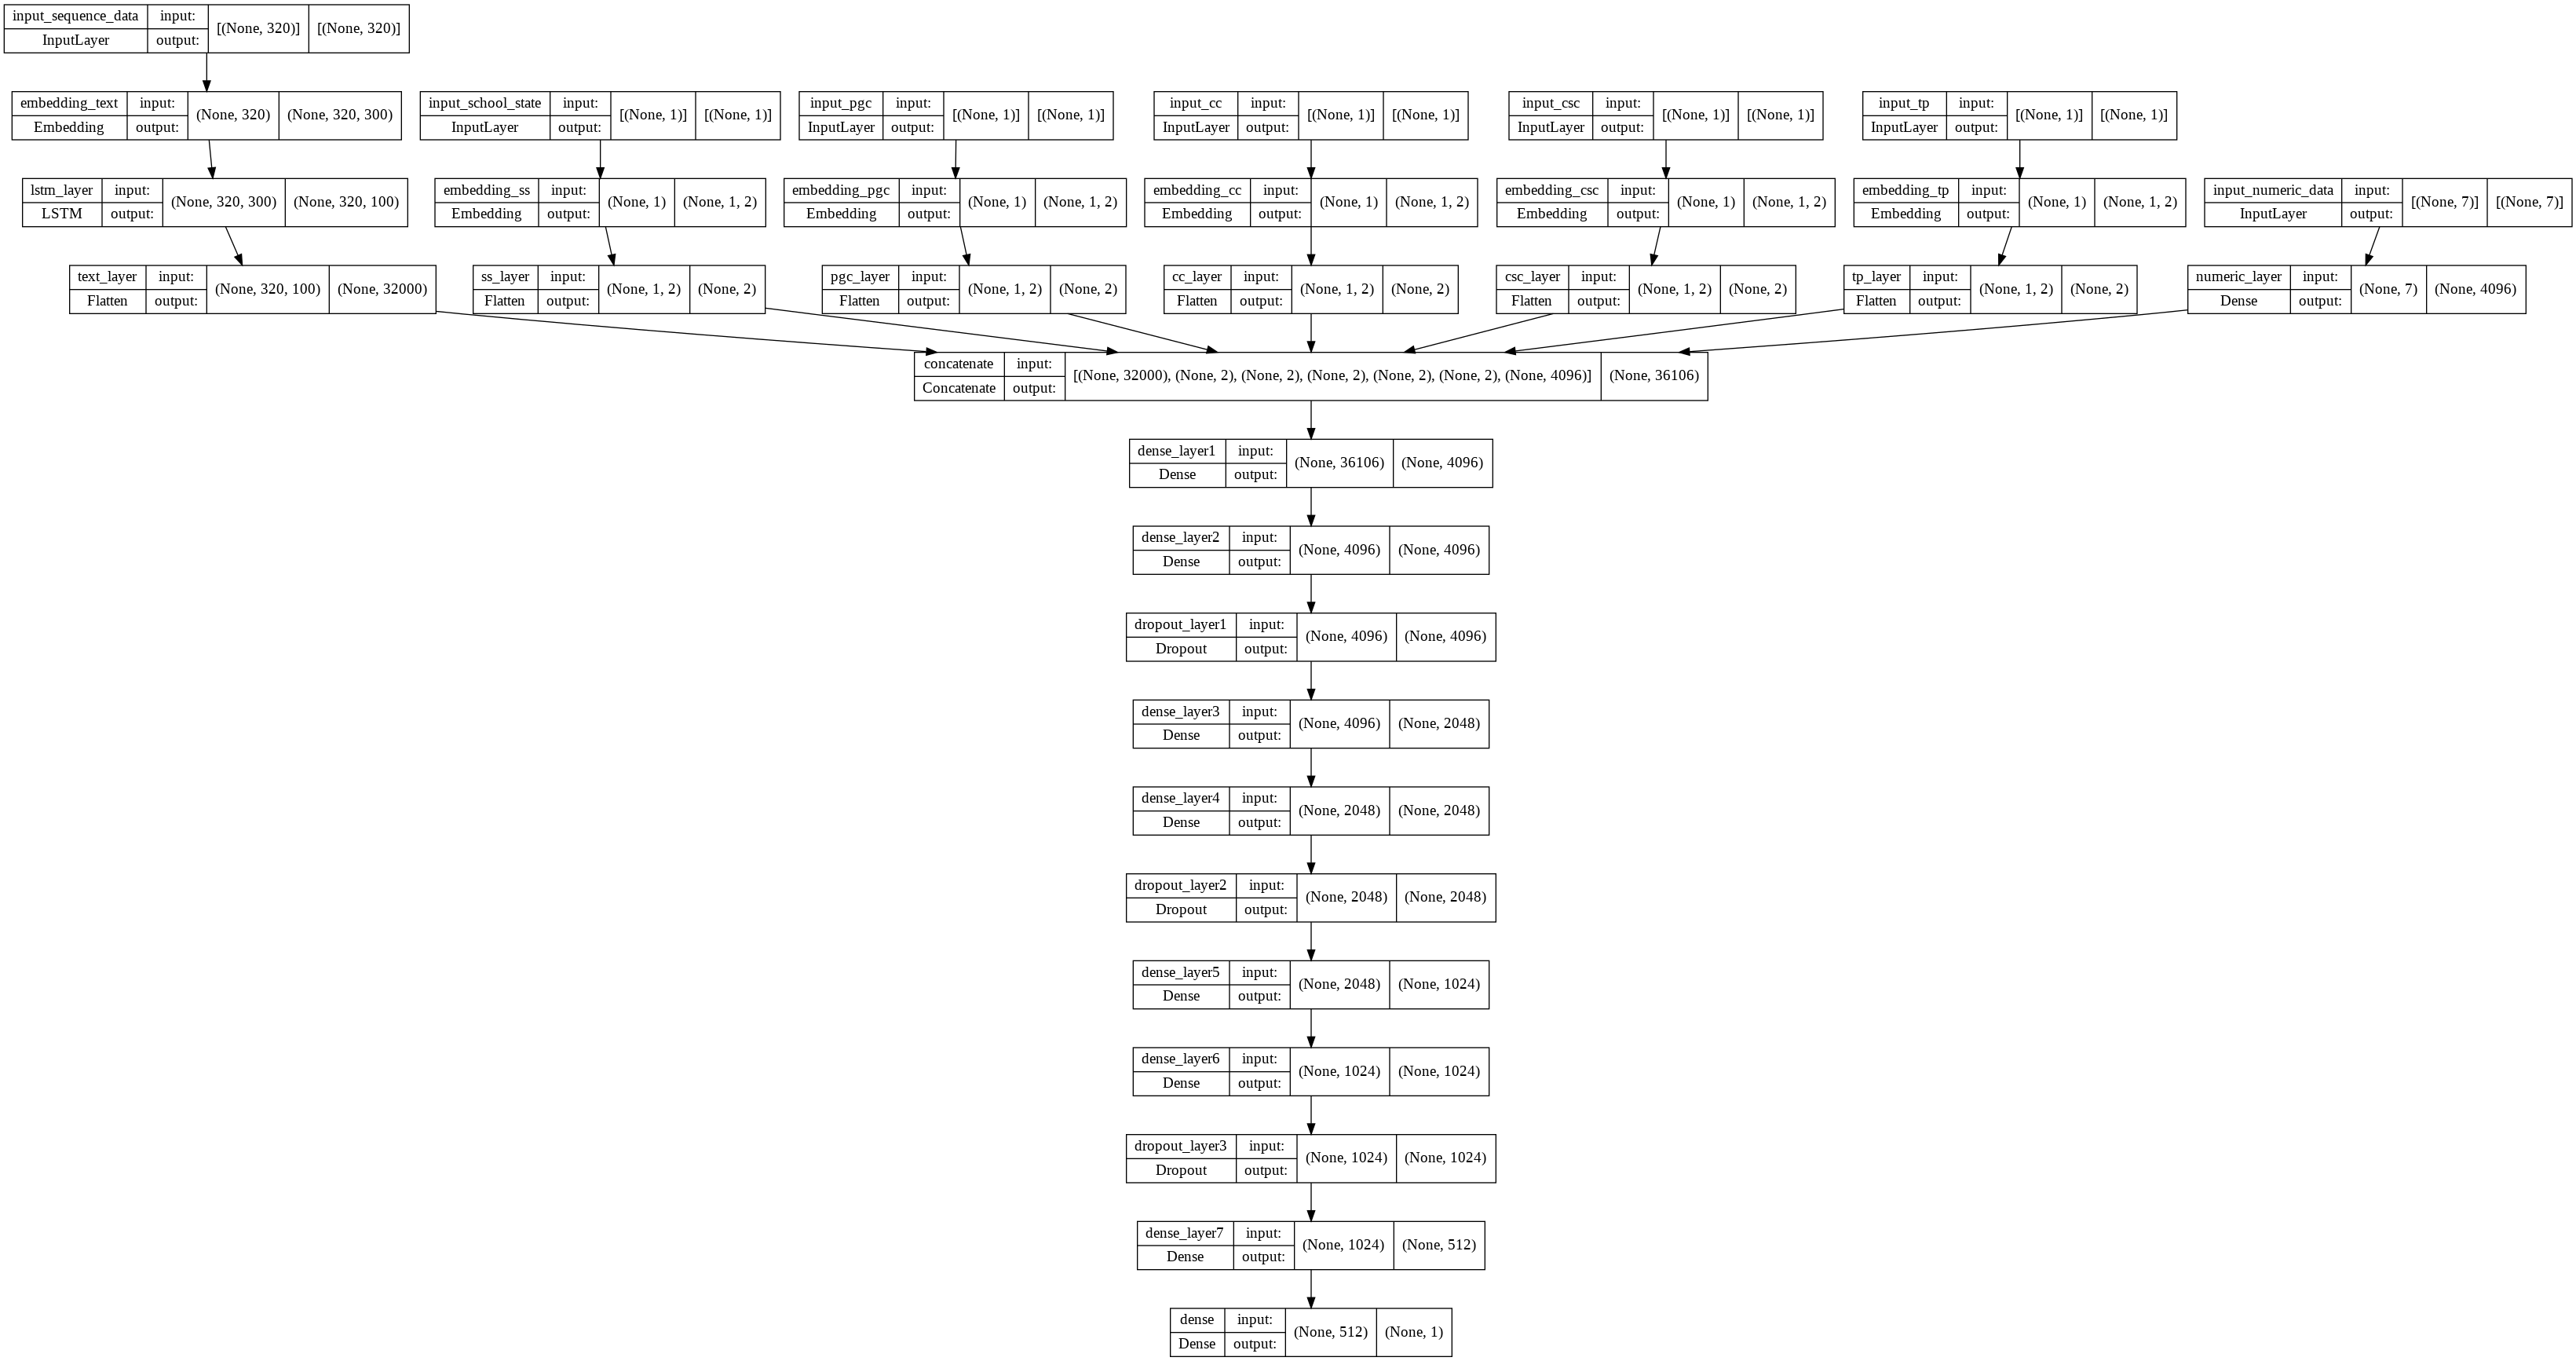

In [ ]:
path = 'model_2.png'
tf.keras.utils.plot_model(model2, to_file=path, show_shapes=True)

## 3.3 LSTM on text feature and CNN on other features (Embedding is Glove and  trainable=False)



In [66]:
from sklearn.preprocessing import OneHotEncoder
ohe_ss = OneHotEncoder(handle_unknown='ignore')

ss_train_ohe = ohe_ss.fit_transform(X_train['school_state'].values.reshape(-1,1))
ss_test_ohe = ohe_ss.transform(X_test['school_state'].values.reshape(-1,1))

In [67]:
ohe_pgc = OneHotEncoder(handle_unknown='ignore')

pgc_train_ohe = ohe_pgc.fit_transform(X_train['project_grade_category'].values.reshape(-1,1))
pgc_test_ohe = ohe_pgc.transform(X_test['project_grade_category'].values.reshape(-1,1))

In [68]:
ohe_psc = OneHotEncoder(handle_unknown='ignore')

cc_train_ohe = ohe_psc.fit_transform(X_train['project_subject_categories'].values.reshape(-1,1))
cc_test_ohe = ohe_psc.transform(X_test['project_subject_categories'].values.reshape(-1,1))

In [69]:
ohe_pssc = OneHotEncoder(handle_unknown='ignore')

csc_train_ohe = ohe_pssc.fit_transform(X_train['project_subject_subcategories'].values.reshape(-1,1))
csc_test_ohe = ohe_pssc.transform(X_test['project_subject_subcategories'].values.reshape(-1,1))

In [70]:
ohe_tp = OneHotEncoder(handle_unknown='ignore')

tp_train_ohe = ohe_tp.fit_transform(X_train['teacher_prefix'].values.reshape(-1,1))
tp_test_ohe = ohe_tp.transform(X_test['teacher_prefix'].values.reshape(-1,1))

In [71]:
pickle.dump((ohe_ss, ohe_pgc, ohe_psc, ohe_pssc, ohe_tp),open('/content/drive/MyDrive/cat_ohe.pkl','wb'))

In [19]:
from scipy import sparse
cat_train_data = np.array(sparse.csr.csr_matrix.todense(sparse.hstack((ss_train_ohe, pgc_train_ohe, cc_train_ohe, csc_train_ohe, tp_train_ohe))))
cat_test_data = np.array(sparse.csr.csr_matrix.todense(sparse.hstack((ss_test_ohe, pgc_test_ohe, cc_test_ohe, csc_test_ohe, tp_test_ohe))))

In [20]:
cat_train_data.shape

(87398, 507)

In [21]:
cat_test_data.shape

(21850, 507)

In [22]:
train_data = np.hstack((cat_train_data, numeric_data_train))
test_data = np.hstack((cat_test_data, numeric_data_test))

In [23]:
train_data = train_data[:,:,np.newaxis]
test_data = test_data[:,:,np.newaxis]

In [24]:
train_data.shape

(87398, 510, 1)

In [25]:
test_data.shape

(21850, 510, 1)

In [31]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
tf.keras.backend.clear_session()
input_sequence_data = Input(shape=(320,), name='input_sequence_data')
embedding_text = Embedding(len(token_text.word_index)+1,embedding_matrix_text_glove.shape[1],
                                 weights=[embedding_matrix_text_glove],input_length=320,trainable=False, name='embedding_text')(input_sequence_data)
lstm_layer = LSTM(100, name= 'lstm_layer')(embedding_text)
flattened_layer_1 = Flatten(name= 'flattened_layer_1')(lstm_layer)

otherthan_text_input = Input(shape=(510,1,), name='Otherthan_text_input')
conv_layer_1 = Conv1D(1024, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_1')(otherthan_text_input)
max_pool_1 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_1')(conv_layer_1)

conv_layer_2 = Conv1D(512, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_2')(max_pool_1)
conv_layer_3 = Conv1D(512, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_3')(conv_layer_2)
max_pool_2 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_2')(conv_layer_3)
conv_layer_4 = Conv1D(256, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_4')(max_pool_2)
conv_layer_5 = Conv1D(256, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_5')(conv_layer_4)
max_pool_3 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_3')(conv_layer_5)
conv_layer_6 = Conv1D(128, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_6')(max_pool_3)
conv_layer_7 = Conv1D(128, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_7')(conv_layer_6)
max_pool_4 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_4')(conv_layer_7)
conv_layer_8 = Conv1D(64, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_8')(max_pool_4)

flattened_layer_2 = Flatten(name= 'flattened_layer_2')(conv_layer_8)

merge_layer = Concatenate(axis=-1)([flattened_layer_1, flattened_layer_2])

dense_layer1 = Dense(4096, activation='relu', kernel_initializer='he_normal', name='dense_layer1')(merge_layer)
dropout_layer1 = Dropout(0.5, name='dropout_layer1')(dense_layer1)
dense_layer2 = Dense(2048, activation='relu', kernel_initializer='he_normal', name='dense_layer2')(dropout_layer1)
dropout_layer2 = Dropout(0.5, name='dropout_layer2')(dense_layer2)
dense_layer3 = Dense(1024, activation='relu', kernel_initializer='he_normal', name='dense_layer3')(dropout_layer2)
dropout_layer3 = Dropout(0.5, name='dropout_layer3')(dense_layer3)
dense_layer4 = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense_layer4')(dropout_layer3)



output_layer = Dense(1, activation='sigmoid')(dense_layer4)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

lr_scheduler =tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

model3 = Model(inputs=[input_sequence_data, otherthan_text_input], outputs= output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model3.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy', auroc])

model3.fit([x_train_padding, train_data], y_train,
          validation_data=([x_test_padding, test_data], y_test), batch_size=300, epochs=20, callbacks=[tensorboard_callback, lr_scheduler])

Epoch 1/20
292/292 [==============================] - 191s 519ms/step - loss: 0.4223 - accuracy: 0.8465 - auroc: 0.6118 - val_loss: 0.4036 - val_accuracy: 0.8486 - val_auroc: 0.6700 - lr: 1.0000e-04
Epoch 2/20
292/292 [==============================] - 149s 510ms/step - loss: 0.4071 - accuracy: 0.8486 - auroc: 0.6589 - val_loss: 0.4035 - val_accuracy: 0.8486 - val_auroc: 0.6750 - lr: 1.0000e-04
Epoch 3/20
292/292 [==============================] - 157s 538ms/step - loss: 0.4047 - accuracy: 0.8486 - auroc: 0.6647 - val_loss: 0.4006 - val_accuracy: 0.8486 - val_auroc: 0.6779 - lr: 1.0000e-04
Epoch 4/20
292/292 [==============================] - 149s 510ms/step - loss: 0.4037 - accuracy: 0.8486 - auroc: 0.6674 - val_loss: 0.4005 - val_accuracy: 0.8486 - val_auroc: 0.6752 - lr: 1.0000e-04
Epoch 5/20
292/292 [==============================] - 157s 538ms/step - loss: 0.4026 - accuracy: 0.8486 - auroc: 0.6704 - val_loss: 0.4008 - val_accuracy: 0.8486 - val_auroc: 0.6770 - lr: 1.0000e-04
Epoch

In [ ]:
model3.save('/content/drive/MyDrive/model3.h5')

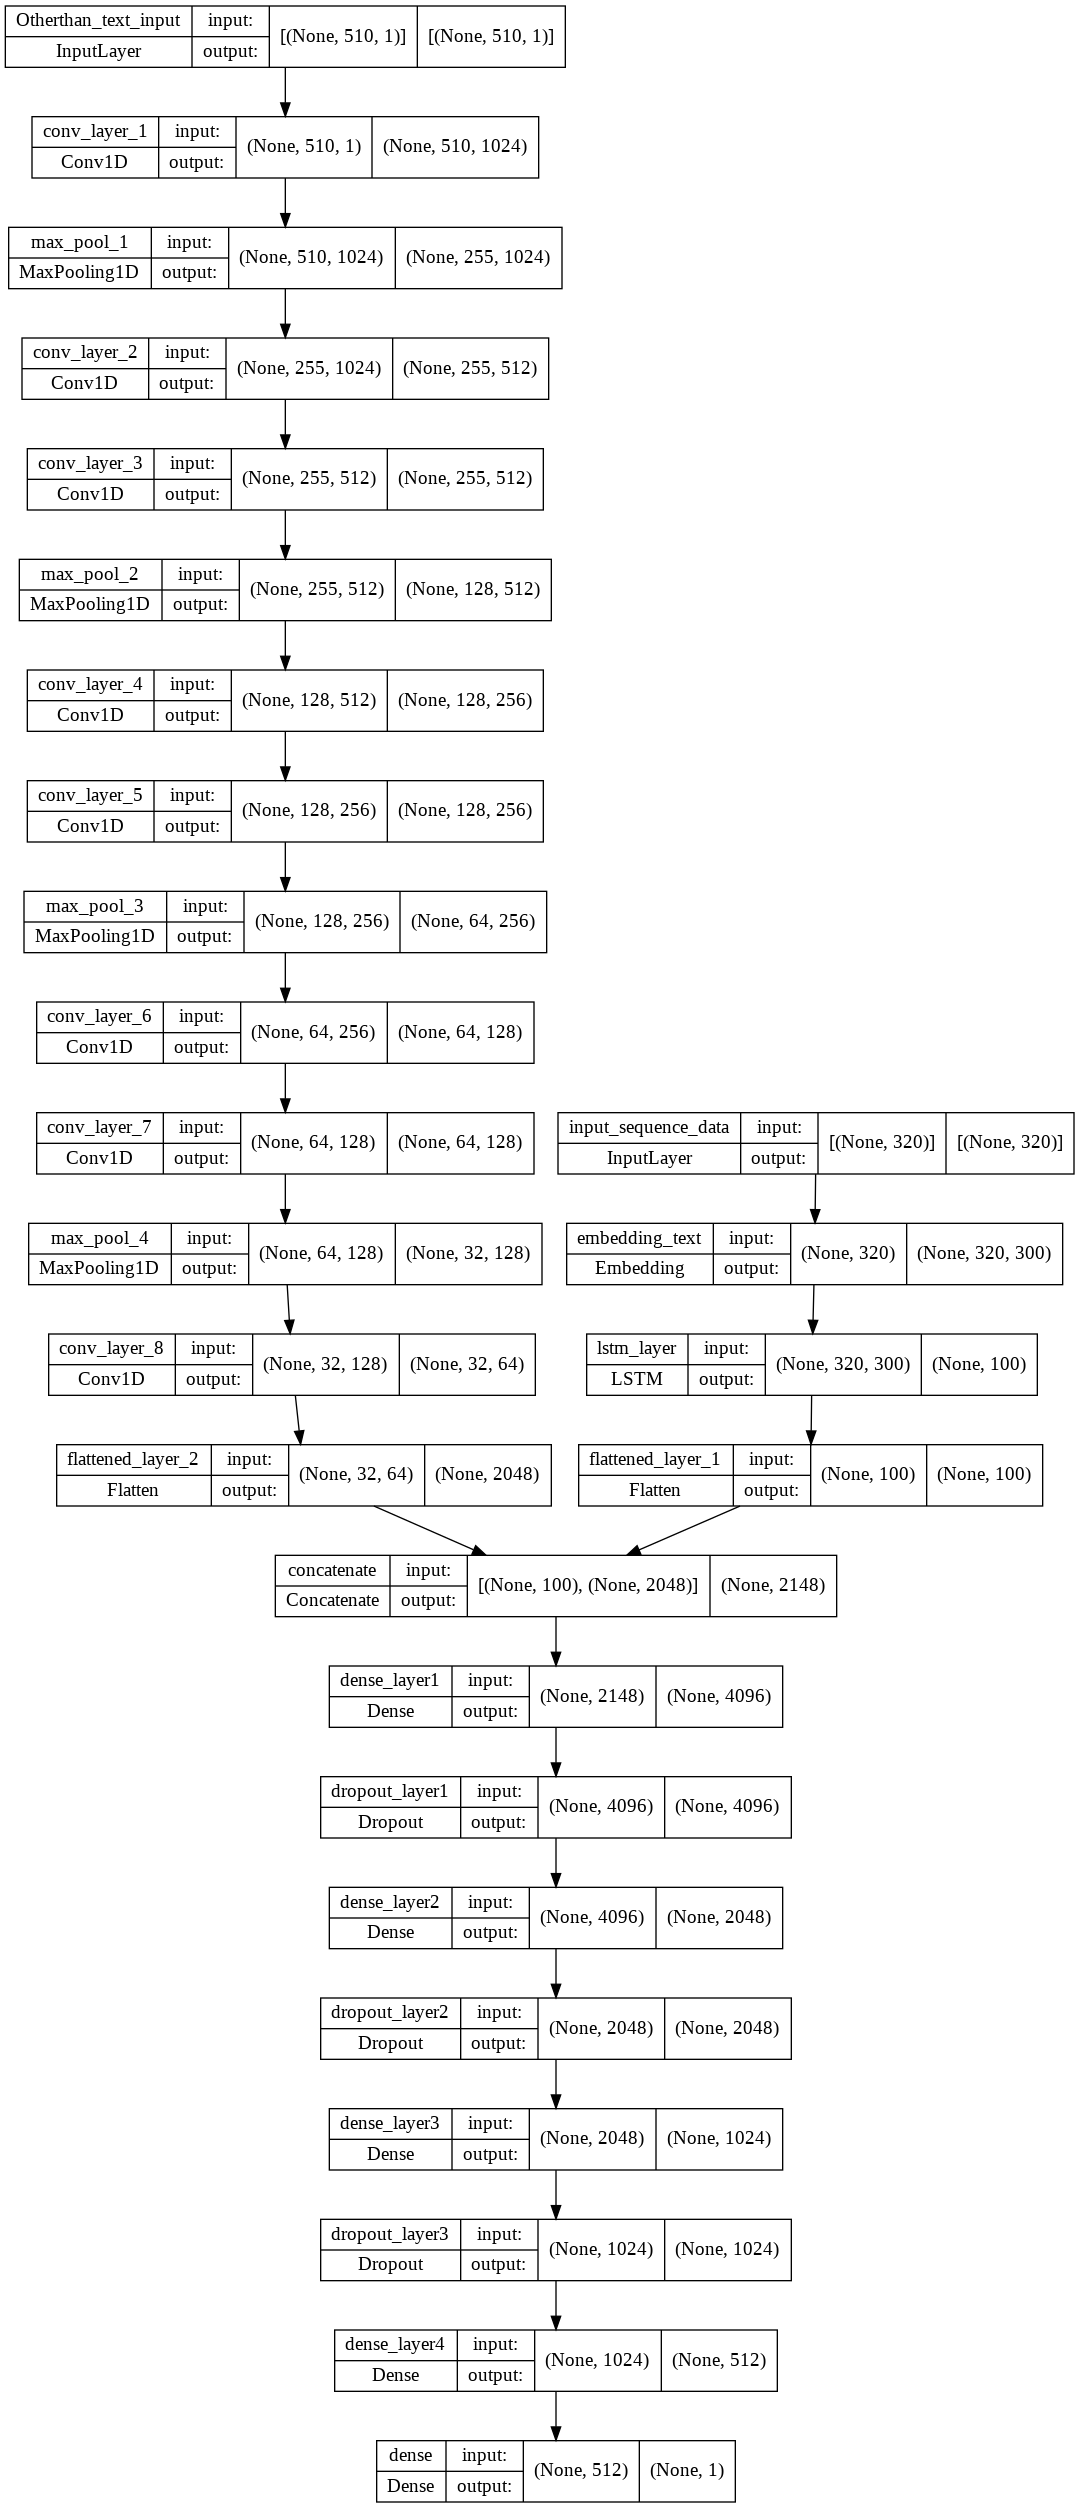

In [ ]:
path = 'model_3.png'
tf.keras.utils.plot_model(model3, to_file=path, show_shapes=True)

## 3.5 Bidirectional LSTM on text data, embedding on categorical and dense on numerical (Embedding is Fast Text trainable=True)

In [48]:
!rm -rf ./logs/ 
tf.keras.backend.clear_session()

input_sequence_data = Input(shape=(320,), name='input_sequence_data')
embedding_text = Embedding(len(token_text.word_index)+1,embedding_matrix_text_fast.shape[1],
                                 weights=[embedding_matrix_text_fast],input_length=320,trainable=True, name='embedding_text')(input_sequence_data)
lstm_layer = Bidirectional(LSTM(100, return_sequences = True, name= 'lstm_layer', dropout=0.35))(embedding_text)
text_layer = Flatten(name= 'text_layer')(lstm_layer)

input_school_state = Input(shape=(1,), name='input_school_state')
embedding_ss = Embedding(len(np.unique(ordinal_encoder_ss_train)), 2, input_length=1, name= 'embedding_ss')(input_school_state)
ss_layer = Flatten(name= 'ss_layer')(embedding_ss)

input_pgc = Input(shape=(1,), name= 'input_pgc')
embedding_pgc = Embedding(len(np.unique(ordinal_encoder_pgc_train)), 2, input_length=1, name= 'embedding_pgc')(input_pgc)
pgc_layer = Flatten(name='pgc_layer')(embedding_pgc)

input_cc = Input(shape=(1,), name= 'input_cc')
embedding_cc = Embedding(len(np.unique(ordinal_encoder_cc_train)), 2, input_length=1, name='embedding_cc')(input_cc)
cc_layer = Flatten(name='cc_layer')(embedding_cc)

input_csc = Input(shape=(1,), name='input_csc')
embedding_csc = Embedding(len(np.unique(ordinal_encoder_csc_train)), 2, input_length=1, name='embedding_csc')(input_csc)
csc_layer = Flatten(name='csc_layer')(embedding_csc)

input_tp = Input(shape=(1,), name='input_tp')
embedding_tp = Embedding(len(np.unique(ordinal_encoder_tp_train)), 2, input_length=1, name='embedding_tp')(input_tp)
tp_layer = Flatten(name='tp_layer')(embedding_tp)

input_numeric_data = Input(shape=(3,), name='input_numeric_data')
numeric_layer = Dense(4096, activation='relu', kernel_initializer='he_normal', name='numeric_layer')(input_numeric_data)

merge_layer = Concatenate(axis=-1)([text_layer, ss_layer, pgc_layer, cc_layer, csc_layer, tp_layer, numeric_layer])

dense_layer1 = Dense(2048, activation='relu', kernel_initializer='he_normal', name='dense_layer1')(merge_layer)
dense_layer2 = Dense(2048, activation='relu', kernel_initializer='he_normal', name='dense_layer2')(dense_layer1)
dropout_layer1 = Dropout(0.5, name='dropout_layer1')(dense_layer2)
dense_layer3 = Dense(1024, activation='relu', kernel_initializer='he_normal', name='dense_layer3')(dropout_layer1)
dense_layer4 = Dense(1024, activation='relu', kernel_initializer='he_normal', name='dense_layer4')(dense_layer3)
dropout_layer2 = Dropout(0.5, name='dropout_layer2')(dense_layer4)
dense_layer5 = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense_layer5')(dropout_layer2)
dense_layer6 = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense_layer6')(dense_layer5)
dropout_layer3 = Dropout(0.5, name='dropout_layer3')(dense_layer6)
dense_layer7 = Dense(256, activation='relu', kernel_initializer='he_normal', name='dense_layer7')(dropout_layer3)


output_layer = Dense(1, activation='sigmoid')(dense_layer7)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
lr_scheduler =tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

model1 = Model(inputs=[input_sequence_data, input_school_state, input_pgc, input_cc, input_csc, input_tp, input_numeric_data], outputs= output_layer)

model1.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy', auroc])

model1.fit([x_train_padding, ordinal_encoder_ss_train, ordinal_encoder_pgc_train, 
           ordinal_encoder_cc_train, ordinal_encoder_csc_train, ordinal_encoder_tp_train, numeric_data_train], y_train, 
          validation_data=([x_test_padding, ordinal_encoder_ss_test, ordinal_encoder_pgc_test, 
           ordinal_encoder_cc_test, ordinal_encoder_csc_test, ordinal_encoder_tp_test, numeric_data_test], y_test), 
           batch_size=1100, epochs=7, callbacks=[tensorboard_callback, lr_scheduler], class_weight=class_weights)

Epoch 1/7
80/80 [==============================] - 68s 791ms/step - loss: 0.8751 - accuracy: 0.7789 - auroc: 0.5847 - val_loss: 0.5375 - val_accuracy: 0.8072 - val_auroc: 0.6741 - lr: 1.0000e-04
Epoch 2/7
80/80 [==============================] - 61s 769ms/step - loss: 0.8064 - accuracy: 0.8026 - auroc: 0.6666 - val_loss: 0.5248 - val_accuracy: 0.7718 - val_auroc: 0.7264 - lr: 1.0000e-04
Epoch 3/7
80/80 [==============================] - 61s 764ms/step - loss: 0.7602 - accuracy: 0.7972 - auroc: 0.7212 - val_loss: 0.5200 - val_accuracy: 0.7588 - val_auroc: 0.7438 - lr: 1.0000e-04
Epoch 4/7
80/80 [==============================] - 61s 763ms/step - loss: 0.7346 - accuracy: 0.8076 - auroc: 0.7444 - val_loss: 0.4834 - val_accuracy: 0.7985 - val_auroc: 0.7552 - lr: 1.0000e-04
Epoch 5/7
80/80 [==============================] - 62s 772ms/step - loss: 0.7149 - accuracy: 0.8146 - auroc: 0.7600 - val_loss: 0.4821 - val_accuracy: 0.8038 - val_auroc: 0.7619 - lr: 1.0000e-04
Epoch 6/7
80/80 [========

In [49]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1)

In [50]:
lr_scheduler =tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

model1.fit([x_train_padding, ordinal_encoder_ss_train, ordinal_encoder_pgc_train, 
           ordinal_encoder_cc_train, ordinal_encoder_csc_train, ordinal_encoder_tp_train, numeric_data_train], y_train, 
          validation_data=([x_test_padding, ordinal_encoder_ss_test, ordinal_encoder_pgc_test, 
           ordinal_encoder_cc_test, ordinal_encoder_csc_test, ordinal_encoder_tp_test, numeric_data_test], y_test), 
           batch_size=1100, epochs=5, callbacks=[tensorboard_callback, lr_scheduler], class_weight=class_weights)

Epoch 1/5
80/80 [==============================] - 63s 781ms/step - loss: 0.6681 - accuracy: 0.8258 - auroc: 0.7990 - val_loss: 0.5059 - val_accuracy: 0.7669 - val_auroc: 0.7649 - lr: 7.4082e-05
Epoch 2/5
80/80 [==============================] - 61s 761ms/step - loss: 0.6520 - accuracy: 0.8264 - auroc: 0.8108 - val_loss: 0.4595 - val_accuracy: 0.7946 - val_auroc: 0.7590 - lr: 6.7032e-05
Epoch 3/5
80/80 [==============================] - 62s 770ms/step - loss: 0.6312 - accuracy: 0.8298 - auroc: 0.8266 - val_loss: 0.4610 - val_accuracy: 0.7922 - val_auroc: 0.7577 - lr: 6.0653e-05
Epoch 4/5
80/80 [==============================] - 61s 761ms/step - loss: 0.6046 - accuracy: 0.8344 - auroc: 0.8435 - val_loss: 0.4408 - val_accuracy: 0.8050 - val_auroc: 0.7491 - lr: 5.4881e-05
Epoch 5/5
80/80 [==============================] - 61s 758ms/step - loss: 0.5793 - accuracy: 0.8399 - auroc: 0.8606 - val_loss: 0.4881 - val_accuracy: 0.7696 - val_auroc: 0.7423 - lr: 4.9659e-05


## 3.6 CNN on text feature and CNN on other features (Embedding is Fast Text and  trainable=True)



In [37]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1)

In [38]:
# Clear any logs from previous runs
!rm -rf ./logs/ 
tf.keras.backend.clear_session()
input_sequence_data = Input(shape=(320,), name='input_sequence_data')
embedding_text = Embedding(len(token_text.word_index)+1,embedding_matrix_text_fast.shape[1],
                                 weights=[embedding_matrix_text_fast],input_length=320,trainable=True, name='embedding_text')(input_sequence_data)


conv_layer_text1 = Conv1D(1024, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_text1')(embedding_text)
max_pool_text1 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_text1')(conv_layer_text1)

conv_layer_text2 = Conv1D(512, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_text2')(max_pool_text1)
conv_layer_text3 = Conv1D(512, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_text3')(conv_layer_text2)
max_pool_text2 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_text2')(conv_layer_text3)
conv_layer_text4 = Conv1D(256, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_text4')(max_pool_text2)
conv_layer_text5 = Conv1D(256, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_text5')(conv_layer_text4)
max_pool_text3 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_text3')(conv_layer_text5)
conv_layer_text6 = Conv1D(128, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_text6')(max_pool_text3)

flattened_layer_1 = Flatten(name= 'flattened_layer_1')(conv_layer_text6)

otherthan_text_input = Input(shape=(510,1,), name='Otherthan_text_input')
conv_layer_1 = Conv1D(1024, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_1')(otherthan_text_input)
max_pool_1 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_1')(conv_layer_1)

conv_layer_2 = Conv1D(512, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_2')(max_pool_1)
conv_layer_3 = Conv1D(512, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_3')(conv_layer_2)
max_pool_2 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_2')(conv_layer_3)
conv_layer_4 = Conv1D(256, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_4')(max_pool_2)
conv_layer_5 = Conv1D(256, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_5')(conv_layer_4)
max_pool_3 = MaxPooling1D(pool_size=2, padding='same', name='max_pool_3')(conv_layer_5)
conv_layer_6 = Conv1D(128, 3, activation='relu',padding="same", kernel_initializer='glorot_uniform', name='conv_layer_6')(max_pool_3)


flattened_layer_2 = Flatten(name= 'flattened_layer_2')(conv_layer_6)

merge_layer = Concatenate(axis=-1)([flattened_layer_1, flattened_layer_2])

dense_layer1 = Dense(4096, activation='relu', kernel_initializer='he_normal', name='dense_layer1')(merge_layer)
dropout_layer1 = Dropout(0.5, name='dropout_layer1')(dense_layer1)
dense_layer2 = Dense(2048, activation='relu', kernel_initializer='he_normal', name='dense_layer2')(dropout_layer1)
dropout_layer2 = Dropout(0.5, name='dropout_layer2')(dense_layer2)
dense_layer3 = Dense(1024, activation='relu', kernel_initializer='he_normal', name='dense_layer3')(dropout_layer2)
dropout_layer3 = Dropout(0.5, name='dropout_layer3')(dense_layer3)
dense_layer4 = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense_layer4')(dropout_layer3)



output_layer = Dense(1, activation='sigmoid')(dense_layer4)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

lr_scheduler =tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

model3 = Model(inputs=[input_sequence_data, otherthan_text_input], outputs= output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model3.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy', auroc])

model3.fit([x_train_padding, train_data], y_train,
          validation_data=([x_test_padding, test_data], y_test), batch_size=300, epochs=3, callbacks=[tensorboard_callback, lr_scheduler])

Epoch 1/3
292/292 [==============================] - 276s 932ms/step - loss: 0.3942 - accuracy: 0.8469 - auroc: 0.6981 - val_loss: 0.3629 - val_accuracy: 0.8576 - val_auroc: 0.7659 - lr: 9.0484e-05
Epoch 2/3
292/292 [==============================] - 290s 993ms/step - loss: 0.3570 - accuracy: 0.8573 - auroc: 0.7783 - val_loss: 0.3582 - val_accuracy: 0.8603 - val_auroc: 0.7779 - lr: 8.1873e-05
Epoch 3/3
292/292 [==============================] - 269s 923ms/step - loss: 0.3426 - accuracy: 0.8639 - auroc: 0.8038 - val_loss: 0.3622 - val_accuracy: 0.8527 - val_auroc: 0.7774 - lr: 7.4082e-05


In [33]:
model3.save('/content/drive/MyDrive/model4.h5')

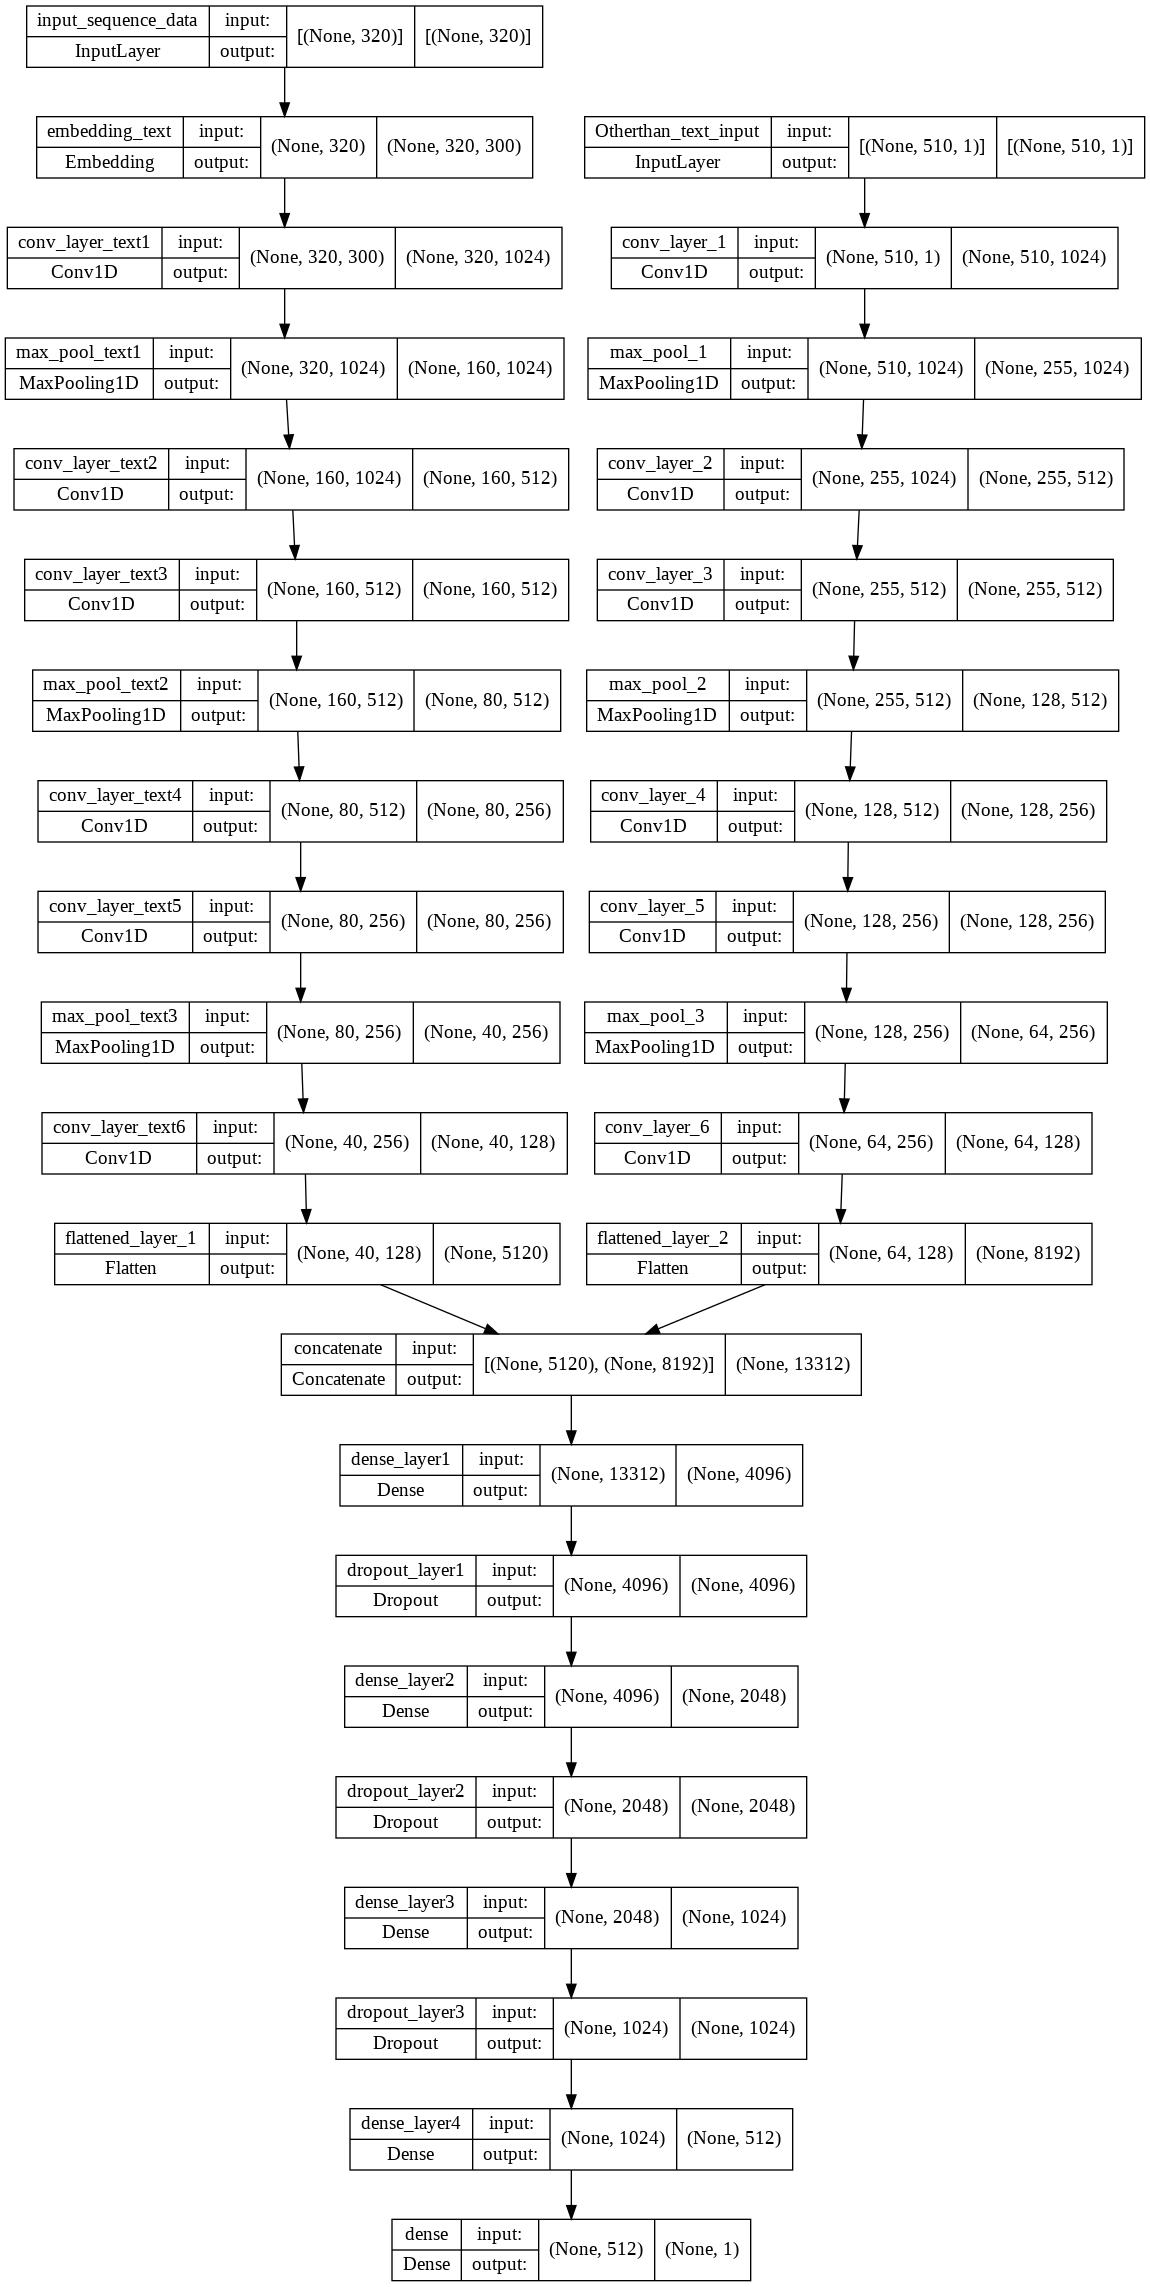

In [34]:
path = 'model_3.png'
tf.keras.utils.plot_model(model3, to_file=path, show_shapes=True)

In [59]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/model4.h5', custom_objects={'auroc': auroc})

In [40]:
y_test_prob = model.predict([x_test_padding, test_data])

y_test_class = []

for i in list(y_test_prob):
  if i >=0.5:
    y_test_class.append(1)
  else:
    y_test_class.append(0)

y_test_class = np.array(y_test_class)

In [54]:
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

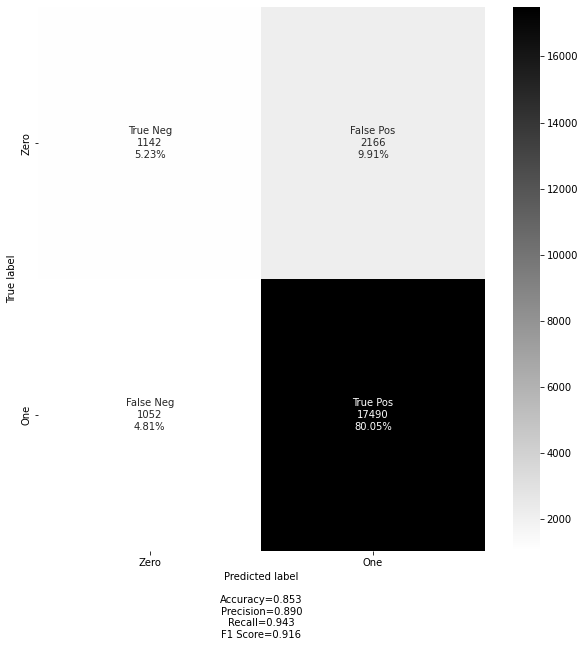

In [57]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(y_test, y_test_class)
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Zero", "One"]
make_confusion_matrix(con_mat, 
                      group_names=labels,
                      categories=categories, 
                      cmap="binary",figsize=(10,10))

In [1]:
from prettytable import PrettyTable
# column names
table = PrettyTable(['Model','Categorical Encoder', 'Embedding(Trainable)', 'Train AUC','Test AUC'])
# rows of the table
table.add_row(['LSTM on text and dense on numerical','Ordinal', 'Glove(True)','0.7662','0.7619'])
table.add_row(['LSTM on text and dense on numerical','Ordinal','FastText(True)','0.7937','0.7643'])
table.add_row(['Bi-LSTM on text and dense on numerical','Ordinal','FastText(True)','0.7862', '0.7653'])
table.add_row(['LSTM on text and CNN on other features','One Hot','Glove(False)','0.7704','0.7522'])
table.add_row(['CNN on text and CNN on other features','One Hot','FastText(True)','0.7862','0.7653'])
table.add_row(['CNN on text and CNN on other features','One Hot','FastText(True)','0.7783', '0.7779'])

print(table)

+----------------------------------------+---------------------+----------------------+-----------+----------+
|                 Model                  | Categorical Encoder | Embedding(Trainable) | Train AUC | Test AUC |
+----------------------------------------+---------------------+----------------------+-----------+----------+
|  LSTM on text and dense on numerical   |       Ordinal       |     Glove(True)      |   0.7662  |  0.7619  |
|  LSTM on text and dense on numerical   |       Ordinal       |    FastText(True)    |   0.7937  |  0.7643  |
| Bi-LSTM on text and dense on numerical |       Ordinal       |    FastText(True)    |   0.7862  |  0.7653  |
| LSTM on text and CNN on other features |       One Hot       |     Glove(False)     |   0.7704  |  0.7522  |
| CNN on text and CNN on other features  |       One Hot       |    FastText(True)    |   0.7862  |  0.7653  |
| CNN on text and CNN on other features  |       One Hot       |    FastText(True)    |   0.7783  |  0.7779  |
+